# Joke's Capstone project

## Finding the similarity between Antwerp districts

![Antwerp Skyline](Antwerp_Skyline.png)

### Introduction/Business Problem

Living in Antwerp myself, I'm interested in knowing which of the districts/area's in Antwerp are most similar to one another when it comes to having similar venues.

The target audience for this investigation is the potential business owner that wants to relocate his business in Antwerp and wants to consider a similar area. Alternatively this investigation can be used by people wanting to move in Antwerp to a similar area as the one they are living in and currently enjoying.

### Data

I will need an overview of the different area's in Antwerp. I will use the following GitHub-csv-file to obtain all Belgian postal codes along with their coordinates: https://github.com/jief/zipcode-belgium/blob/master/zipcode-belgium.csv

An example extract of this list of postal codes can be found below:

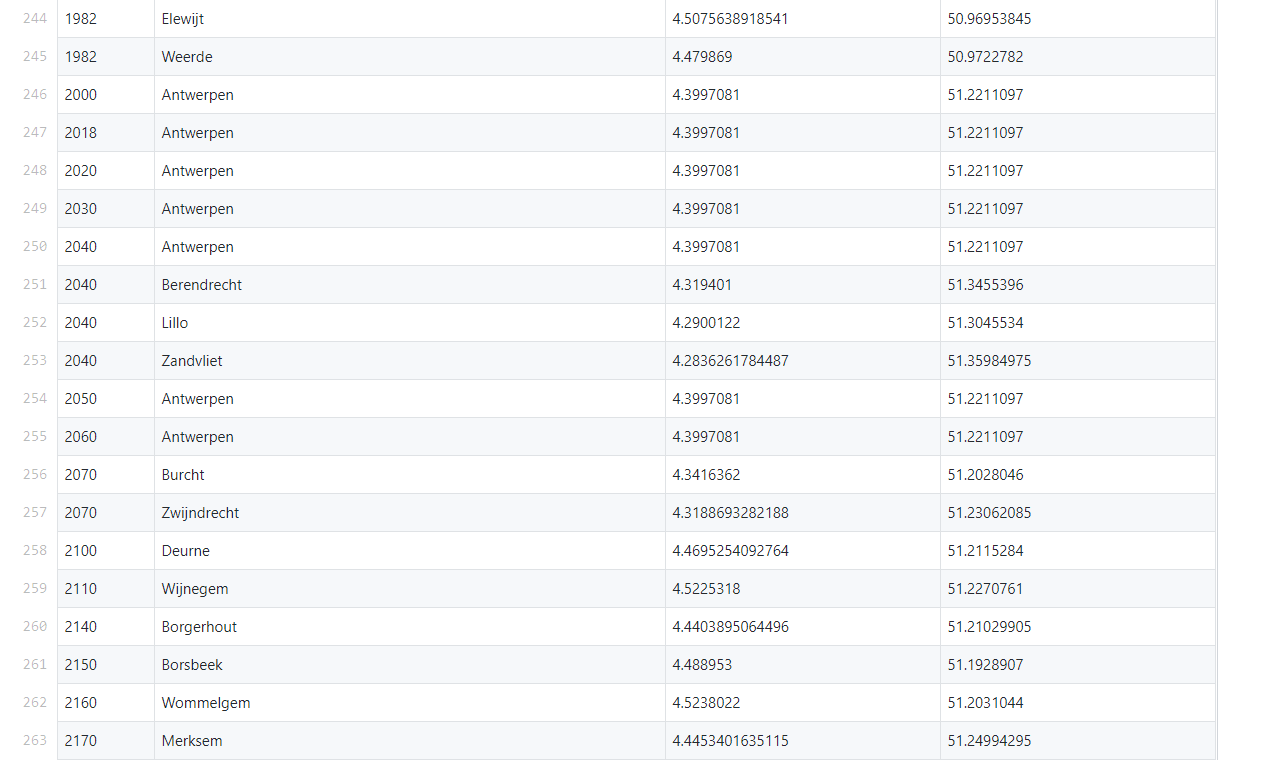

I will scrape this page to get a list of the Antwerp postal codes to filter the above data to only Antwerp codes: https://postcode.nationaal.be/resultaat2.php?gem=Antwerpen

The list can be found below:

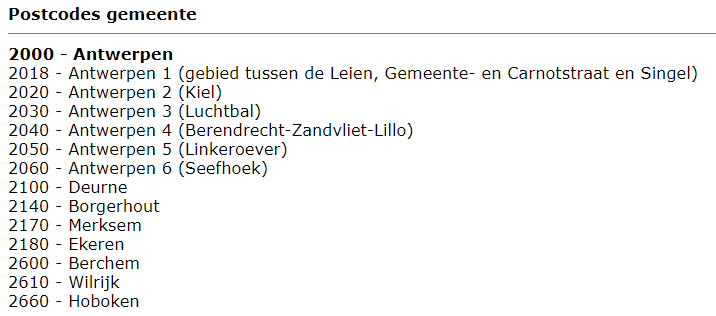

I will need the Foursquare API to retrieve the venues for each of the area's.